In [1]:
import math
import numpy as np
import matplotlib.pylab as plt
np.set_printoptions(precision=2)
import scipy.io as sio
import random

Hledání parametrů

In [2]:
# activeL má formát 2D matice, je indexovaná číslem sloupce matice a každý index obsahuje pole čísel reprezentující řádek (odpovídá )

# příklad activeL, které odpovídá spodní diagonále
activeL = [
    [1],
    [2],
    [3],
    [4],
    [5],
    [6],
    [7],
    [8],
    [9],
    [10],
    [11],
    [12],
    [13],
    [14],
    [15],
    [16],
    [17],
    [18],
    [19],
    [20],
    [21],
    [22],
    [23],
    [24],
    [25],
    [26],
    [27],
    [28],
    [29],
    [30],
    [31],
    [32],
    [33],
    [34],
    [35],
]


import sys
sys.path.append('..')
from ModelsCollection import bayesGeneralLVLRegression,bayesLVLGeneralPositiveRegression

# Příprava syntetických dat

sMatrix - skutečná matice průběhu
- řádek představuje jedno políčko z mapy 3x3 (9 políček), číslováno z levého horního rohu 
- sloupec představuje čas měření

## Symbolický náčrt situace:

|  |  |  |
|-----------|-----------|-----------|
| 0 | 0 | release1 |
| release4 | release3 | release2 |
| 0 | 0 | 0 |

Kde v rámci časů 1,2,3,4:
- release 1: 2,2,0,0
- release 2: 0,3,3,0
- release 3: 0,0,1,1
- release 4: 0,0,0,2

In [3]:
sMatrix = np.matrix(
    [
        [0,0,0,0],
        [0,0,0,0],
        [2,2,0,0],
        [0,0,0,2],
        [0,0,1,1],
        [0,3,3,0],
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0]
    ])

In [4]:
def generate_xk(p, seed):
    """
    Generates data from single point on map
    """
    rng = np.random.default_rng(seed=seed)
    # X random čísla z <0,10)
    output = [10 * rng.random(size=p) for i in range(0,4)]

    # transpozice, aby sloupce odpovídaly časům
    return np.matrix(output).T.A

def generate_X(p, seed=40693057):
    """
    Returns data matrix X
    """
    random.seed(seed)
    seeds = [random.randint(0,10000) for i in range(0,9)]
    
    tmp = [generate_xk(p, seeds[i]) for i in range(0,len(seeds))]

    finalX = np.zeros((p,9*4))
    for i in range(0,9):
        finalX[:, 0+4*i:4+4*i] = tmp[i]

    return finalX

def generate_y(X, sMatrixTrue, seed=40693057, sigma=1):
    rng = np.random.default_rng(seed=seed)
    
    output_y = np.multiply(X, sMatrix.flatten()).sum(axis=1)
    output_y = (output_y + rng.normal(loc=0, scale=sigma, size=1)).A
    # pro jistotu nahradím hodnoty menší než 0, 0
    output_y[output_y < 0] = 0

    return output_y

# Generování dat - vygenerování dat
- $X_{i,j} \in [0,10), \forall i,j$
- $err_i \sim N(\mu = 0,\sigma^2 = 2), \forall i$

In [5]:
p = 100
seed = 40693057
X = generate_X(p,seed=seed)
y = generate_y(X, sMatrix, sigma=np.sqrt(2),seed=seed)
beta_true = sMatrix.flatten().T

dataDic = {"X":X,"y":y,"beta_true":beta_true}
sio.savemat("fireData.mat", dataDic)

In [6]:
X = sio.loadmat("fireData.mat")["X"]
y = sio.loadmat("fireData.mat")["y"]
beta_true = sio.loadmat("fireData.mat")["beta_true"]

## Model s vedlejší diagonálou

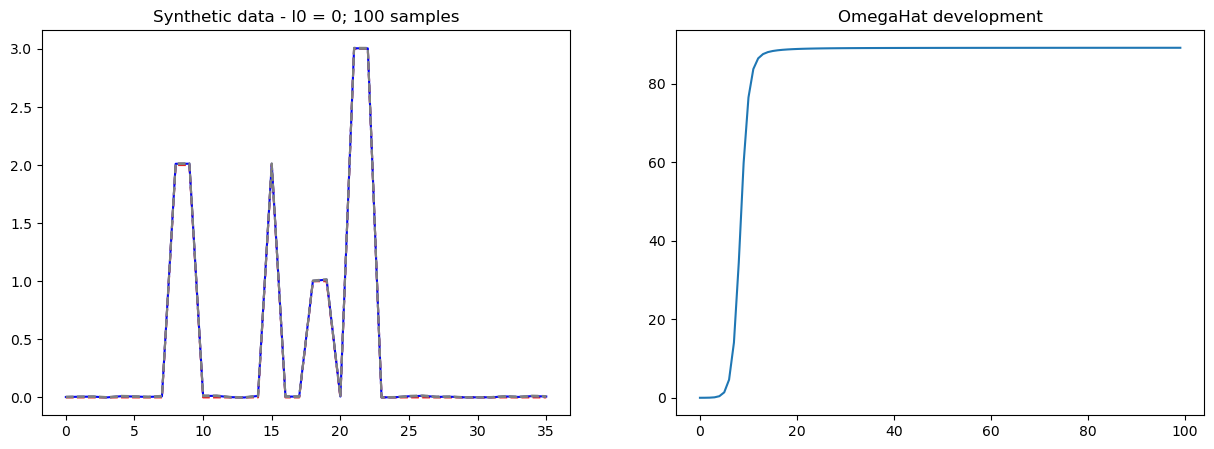

In [7]:
activeL = [
    [1], # 1, t0
    [2], # 1, t1
    [3], # 1, t2
    [4], # 1, t3
    [5], # 2, t0
    [6], # 2, t1
    [7], # 2, t2
    [8], # 2, t3
    [9], # 3, t0
    [10], # 3, t1
    [11], # 3, t2
    [12], # 3, t3
    [13], # 4, t0
    [14], # 4, t1
    [15], # 4, t2
    [16], # 4, t3
    [17], # 5, t0
    [18], # 5, t1
    [19], # 5, t2
    [20], # 5, t3
    [21], # 6, t0
    [22], # 6, t1
    [23], # 6, t2
    [24], # 6, t3
    [25], # 7, t0
    [26], # 7, t1
    [27], # 7, t2
    [28], # 7, t3
    [29], # 8, t0
    [30], # 8, t1
    [31], # 8, t2
    [32], # 8, t3
    [33], # 9, t0
    [34], # 9, t1
    [35], # 9, t2
]
l0 = 0

betaHat, sigmaBeta, hist_omega = bayesGeneralLVLRegression(X,y,l0,activeL)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(beta_true,color='red',linestyle='dashed')
axs[0].plot(betaHat,color = 'blue')
unc_1 = np.matrix(betaHat) + np.matrix(np.sqrt(np.diag(sigmaBeta))).T
unc_2 = np.matrix(betaHat) - np.matrix(np.sqrt(np.diag(sigmaBeta))).T
axs[0].plot(unc_1,color = 'grey',linestyle='dashed')
axs[0].plot(unc_2,color = 'grey',linestyle='dashed')
axs[0].set_title(f"Synthetic data - l0 = {l0}; {p} samples")


axs[1].plot(hist_omega)
axs[1].set_title("OmegaHat development")
plt.show()

In [8]:
betaHat - beta_true

array([[ 3.22e-03],
       [ 5.35e-03],
       [ 6.13e-03],
       [-2.06e-04],
       [ 9.56e-03],
       [ 7.10e-03],
       [ 3.80e-03],
       [ 8.68e-03],
       [ 1.08e-02],
       [ 1.13e-02],
       [ 1.24e-02],
       [ 1.28e-02],
       [ 1.76e-03],
       [-9.27e-04],
       [ 1.22e-02],
       [ 1.08e-02],
       [ 7.19e-03],
       [ 5.88e-03],
       [ 2.54e-03],
       [ 1.34e-02],
       [ 7.15e-03],
       [ 5.25e-03],
       [ 4.33e-03],
       [ 7.39e-05],
       [ 1.12e-03],
       [ 9.55e-03],
       [ 1.31e-02],
       [ 4.39e-03],
       [ 5.61e-03],
       [ 2.76e-04],
       [ 4.45e-04],
       [ 8.50e-04],
       [ 8.00e-03],
       [ 3.75e-03],
       [ 1.11e-02],
       [ 7.45e-03]])

In [9]:
beta_true

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [1],
       [1],
       [0],
       [3],
       [3],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

## Korelace 0 s jistou 0

35 odpovídá políčku 9 v čase t3

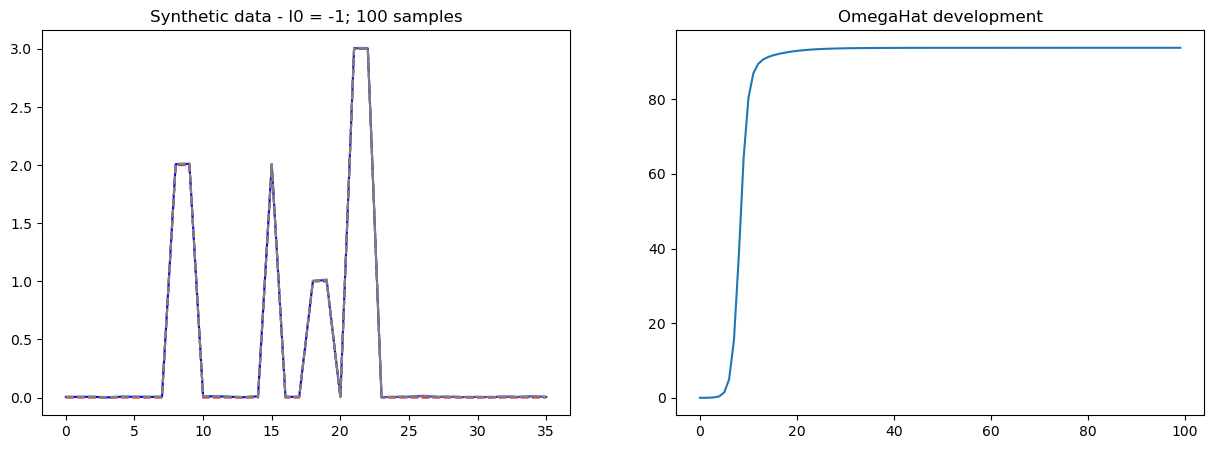

In [10]:
activeL = [
    [35], # 1, t0
    [35], # 1, t1
    [35], # 1, t2
    [35], # 1, t3
    [35], # 2, t0
    [35], # 2, t1
    [35], # 2, t2
    [35], # 2, t3
    [], # 3, t0
    [], # 3, t1
    [35], # 3, t2
    [35], # 3, t3
    [35], # 4, t0
    [35], # 4, t1
    [35], # 4, t2
    [], # 4, t3
    [35], # 5, t0
    [35], # 5, t1
    [], # 5, t2
    [], # 5, t3
    [35], # 6, t0
    [], # 6, t1
    [], # 6, t2
    [35], # 6, t3
    [35], # 7, t0
    [35], # 7, t1
    [35], # 7, t2
    [35], # 7, t3
    [35], # 8, t0
    [35], # 8, t1
    [35], # 8, t2
    [35], # 8, t3
    [35], # 9, t0
    [35], # 9, t1
    [35], # 9, t2
]
l0 = -1

betaHat, sigmaBeta, hist_omega = bayesGeneralLVLRegression(X,y,l0,activeL)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(beta_true,color='red',linestyle='dashed')
axs[0].plot(betaHat,color = 'blue')
unc_1 = np.matrix(betaHat) + np.matrix(np.sqrt(np.diag(sigmaBeta))).T
unc_2 = np.matrix(betaHat) - np.matrix(np.sqrt(np.diag(sigmaBeta))).T
axs[0].plot(unc_1,color = 'grey',linestyle='dashed')
axs[0].plot(unc_2,color = 'grey',linestyle='dashed')
axs[0].set_title(f"Synthetic data - l0 = {l0}; {p} samples")


axs[1].plot(hist_omega)
axs[1].set_title("OmegaHat development")
plt.show()

In [11]:
betaHat - beta_true

array([[0.  ],
       [0.01],
       [0.01],
       [0.  ],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.  ],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.  ],
       [0.01],
       [0.01],
       [0.01],
       [0.  ],
       [0.  ],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.01],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.01],
       [0.  ],
       [0.01],
       [0.01]])

## Korelovanost nenul s nenulou

22 odpovídá políčku 6 v čase t3

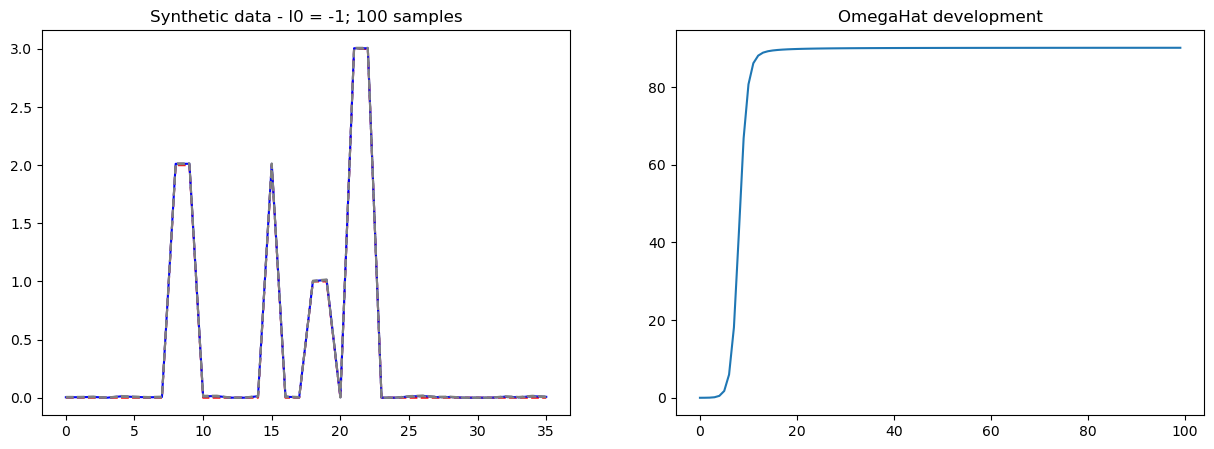

In [12]:
activeL = [
    [], # 1, t0
    [], # 1, t1
    [], # 1, t2
    [], # 1, t3
    [], # 2, t0
    [], # 2, t1
    [], # 2, t2
    [], # 2, t3
    [22], # 3, t0
    [22], # 3, t1
    [], # 3, t2
    [], # 3, t3
    [], # 4, t0
    [], # 4, t1
    [], # 4, t2
    [22], # 4, t3
    [], # 5, t0
    [], # 5, t1
    [22], # 5, t2
    [22], # 5, t3
    [], # 6, t0
    [22], # 6, t1
    [], # 6, t2
    [], # 6, t3
    [], # 7, t0
    [], # 7, t1
    [], # 7, t2
    [], # 7, t3
    [], # 8, t0
    [], # 8, t1
    [], # 8, t2
    [], # 8, t3
    [], # 9, t0
    [], # 9, t1
    [], # 9, t2
]
l0 = -1

betaHat, sigmaBeta, hist_omega = bayesGeneralLVLRegression(X,y,l0,activeL)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(beta_true,color='red',linestyle='dashed')
axs[0].plot(betaHat,color = 'blue')
unc_1 = np.matrix(betaHat) + np.matrix(np.sqrt(np.diag(sigmaBeta))).T
unc_2 = np.matrix(betaHat) - np.matrix(np.sqrt(np.diag(sigmaBeta))).T
axs[0].plot(unc_1,color = 'grey',linestyle='dashed')
axs[0].plot(unc_2,color = 'grey',linestyle='dashed')
axs[0].set_title(f"Synthetic data - l0 = {l0}; {p} samples")


axs[1].plot(hist_omega)
axs[1].set_title("OmegaHat development")
plt.show()

## Korelovanost sousedních časů a políček

Zavedl jsem korelaci mezi sousedními políčkami v čase i+1. Tedy políčko 1 v čase 0 ovlivní políčko 1,2,4 v čase 1

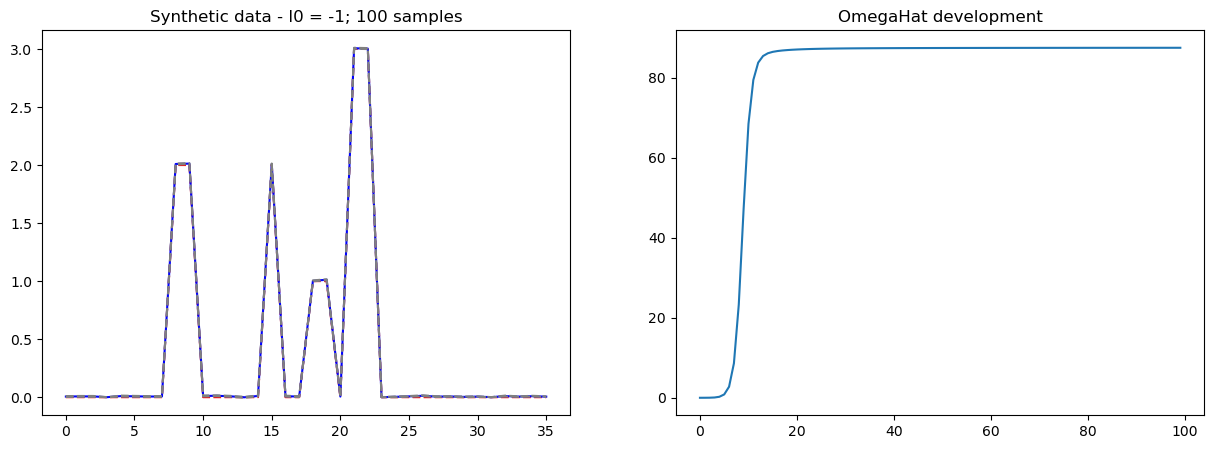

In [13]:
activeL = [
    [1,5,13], # 1, t0
    [2,6,14], # 1, t1
    [3,7,15], # 1, t2
    [], # 1, t3
    [5,9,17], # 2, t0
    [6,10,18], # 2, t1
    [7,11,19], # 2, t2
    [], # 2, t3
    [21], # 3, t0
    [22], # 3, t1
    [23], # 3, t2
    [], # 3, t3
    [17,25], # 4, t0
    [18,26], # 4, t1
    [19,27], # 4, t2
    [], # 4, t3
    [21,29], # 5, t0
    [22,30], # 5, t1
    [23,31], # 5, t2
    [], # 5, t3
    [33], # 6, t0
    [34], # 6, t1
    [35], # 6, t2
    [], # 6, t3
    [29], # 7, t0
    [30], # 7, t1
    [31], # 7, t2
    [], # 7, t3
    [33], # 8, t0
    [34], # 8, t1
    [35], # 8, t2
    [], # 8, t3
    [], # 9, t0
    [], # 9, t1
    [], # 9, t2
]
l0 = -1

betaHat, sigmaBeta, hist_omega = bayesGeneralLVLRegression(X,y,l0,activeL)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(beta_true,color='red',linestyle='dashed')
axs[0].plot(betaHat,color = 'blue')
unc_1 = np.matrix(betaHat) + np.matrix(np.sqrt(np.diag(sigmaBeta))).T
unc_2 = np.matrix(betaHat) - np.matrix(np.sqrt(np.diag(sigmaBeta))).T
axs[0].plot(unc_1,color = 'grey',linestyle='dashed')
axs[0].plot(unc_2,color = 'grey',linestyle='dashed')
axs[0].set_title(f"Synthetic data - l0 = {l0}; {p} samples")


axs[1].plot(hist_omega)
axs[1].set_title("OmegaHat development")
plt.show()

In [14]:
betaHat - beta_true

array([[ 5.56e-03],
       [ 6.72e-03],
       [ 6.40e-03],
       [-1.10e-05],
       [ 9.28e-03],
       [ 7.36e-03],
       [ 5.39e-03],
       [ 5.97e-03],
       [ 8.89e-03],
       [ 1.22e-02],
       [ 1.03e-02],
       [ 1.22e-02],
       [ 7.36e-03],
       [-9.34e-04],
       [ 1.04e-02],
       [ 8.90e-03],
       [ 8.66e-03],
       [ 4.67e-03],
       [ 2.10e-03],
       [ 1.18e-02],
       [ 5.31e-03],
       [ 6.05e-03],
       [ 3.24e-03],
       [ 3.00e-05],
       [ 3.00e-03],
       [ 6.91e-03],
       [ 1.21e-02],
       [ 4.98e-03],
       [ 6.10e-03],
       [ 2.60e-03],
       [ 4.82e-03],
       [ 6.31e-05],
       [ 9.49e-03],
       [ 5.01e-03],
       [ 8.47e-03],
       [ 4.65e-03]])

In [15]:
np.around(betaHat,2)

array([[ 0.01],
       [ 0.01],
       [ 0.01],
       [-0.  ],
       [ 0.01],
       [ 0.01],
       [ 0.01],
       [ 0.01],
       [ 2.01],
       [ 2.01],
       [ 0.01],
       [ 0.01],
       [ 0.01],
       [-0.  ],
       [ 0.01],
       [ 2.01],
       [ 0.01],
       [ 0.  ],
       [ 1.  ],
       [ 1.01],
       [ 0.01],
       [ 3.01],
       [ 3.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.01],
       [ 0.01],
       [ 0.  ],
       [ 0.01],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.01],
       [ 0.01],
       [ 0.01],
       [ 0.  ]])

In [16]:
np.round(beta_true)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [0],
       [0],
       [1],
       [1],
       [0],
       [3],
       [3],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

## Korelace sousedních políček, pozitivita

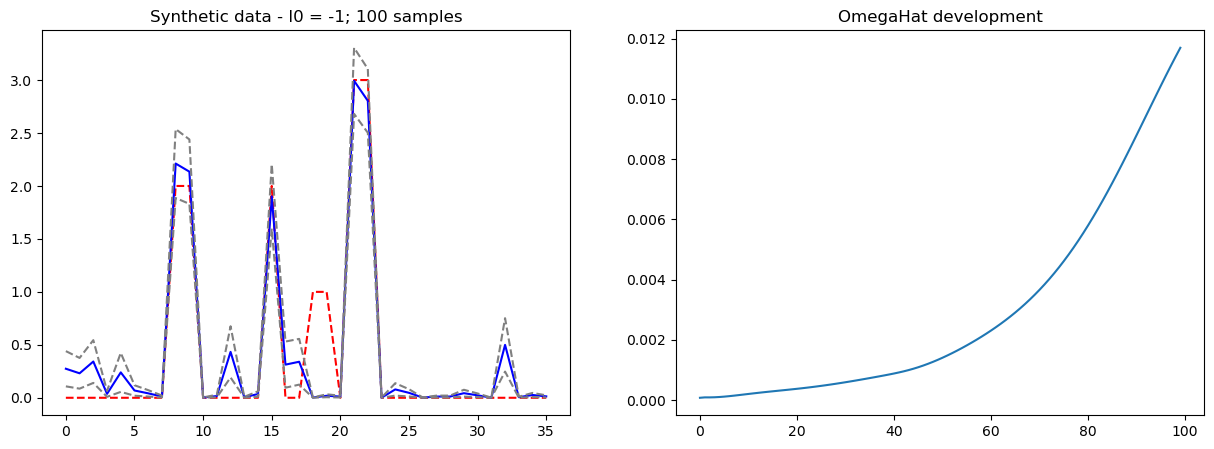

In [20]:
activeL = [
    [1,5,13], # 1, t0
    [2,6,14], # 1, t1
    [3,7,15], # 1, t2
    [], # 1, t3
    [5,9,17], # 2, t0
    [6,10,18], # 2, t1
    [7,11,19], # 2, t2
    [], # 2, t3
    [21], # 3, t0
    [22], # 3, t1
    [23], # 3, t2
    [], # 3, t3
    [17,25], # 4, t0
    [18,26], # 4, t1
    [19,27], # 4, t2
    [], # 4, t3
    [21,29], # 5, t0
    [22,30], # 5, t1
    [23,31], # 5, t2
    [], # 5, t3
    [33], # 6, t0
    [34], # 6, t1
    [35], # 6, t2
    [], # 6, t3
    [29], # 7, t0
    [30], # 7, t1
    [31], # 7, t2
    [], # 7, t3
    [33], # 8, t0
    [34], # 8, t1
    [35], # 8, t2
    [], # 8, t3
    [], # 9, t0
    [], # 9, t1
    [], # 9, t2
]
l0 = -1

betaHat, sigmaBeta, hist_omega = bayesLVLGeneralPositiveRegression(X,y,l0, activeL)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(beta_true,color='red',linestyle='dashed')
axs[0].plot(betaHat,color = 'blue')
unc_1 = np.matrix(betaHat) + np.matrix(np.sqrt((sigmaBeta)))
unc_2 = np.matrix(betaHat) - np.matrix(np.sqrt((sigmaBeta)))
axs[0].plot(unc_1,color = 'grey',linestyle='dashed')
axs[0].plot(unc_2,color = 'grey',linestyle='dashed')

axs[0].set_title(f"Synthetic data - l0 = {l0}; {p} samples")


axs[1].plot(hist_omega)
axs[1].set_title("OmegaHat development")
plt.show()

## Korelace 0 s jistou 0

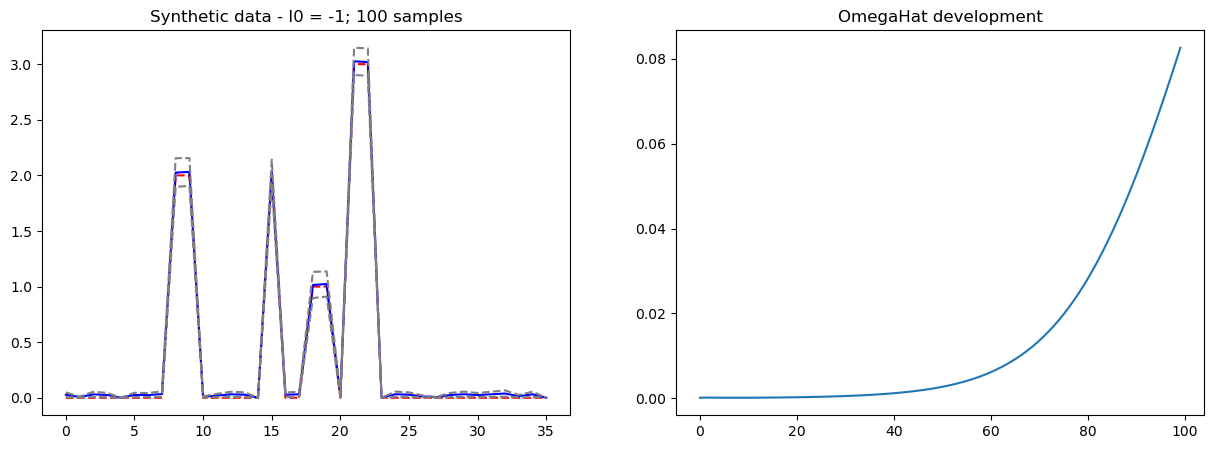

In [22]:
activeL = [
    [35], # 1, t0
    [35], # 1, t1
    [35], # 1, t2
    [35], # 1, t3
    [35], # 2, t0
    [35], # 2, t1
    [35], # 2, t2
    [35], # 2, t3
    [], # 3, t0
    [], # 3, t1
    [35], # 3, t2
    [35], # 3, t3
    [35], # 4, t0
    [35], # 4, t1
    [35], # 4, t2
    [], # 4, t3
    [35], # 5, t0
    [35], # 5, t1
    [], # 5, t2
    [], # 5, t3
    [35], # 6, t0
    [], # 6, t1
    [], # 6, t2
    [35], # 6, t3
    [35], # 7, t0
    [35], # 7, t1
    [35], # 7, t2
    [35], # 7, t3
    [35], # 8, t0
    [35], # 8, t1
    [35], # 8, t2
    [35], # 8, t3
    [35], # 9, t0
    [35], # 9, t1
    [35], # 9, t2
]
l0 = -1

betaHat, sigmaBeta, hist_omega = bayesLVLGeneralPositiveRegression(X,y,l0, activeL)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(beta_true,color='red',linestyle='dashed')
axs[0].plot(betaHat,color = 'blue')
unc_1 = np.matrix(betaHat) + np.matrix(np.sqrt((sigmaBeta)))
unc_2 = np.matrix(betaHat) - np.matrix(np.sqrt((sigmaBeta)))
axs[0].plot(unc_1,color = 'grey',linestyle='dashed')
axs[0].plot(unc_2,color = 'grey',linestyle='dashed')

axs[0].set_title(f"Synthetic data - l0 = {l0}; {p} samples")


axs[1].plot(hist_omega)
axs[1].set_title("OmegaHat development")
plt.show()

## Korelace nenul s nenulou

22 odpovídá políčku 6 v čase t2

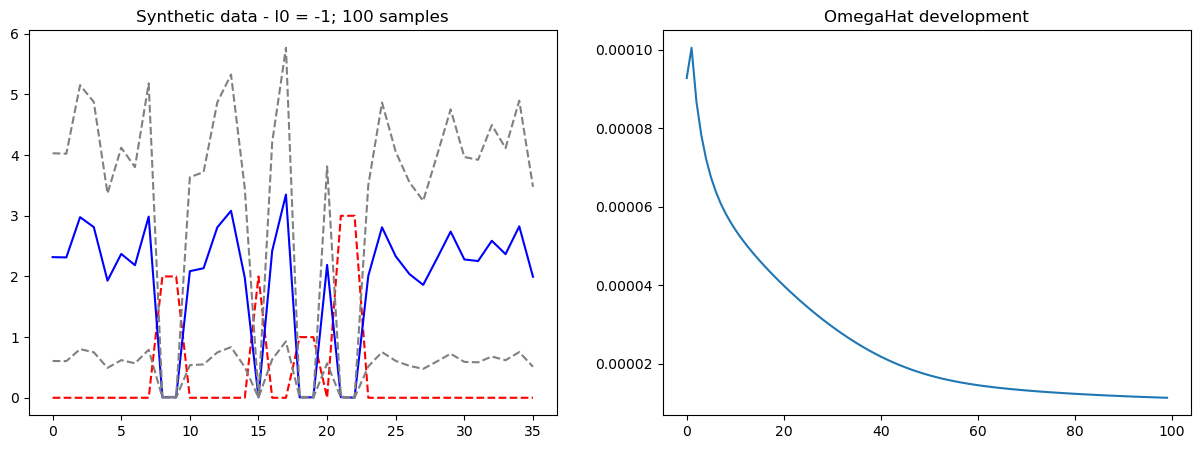

In [23]:
activeL = [
    [], # 1, t0
    [], # 1, t1
    [], # 1, t2
    [], # 1, t3
    [], # 2, t0
    [], # 2, t1
    [], # 2, t2
    [], # 2, t3
    [22], # 3, t0
    [22], # 3, t1
    [], # 3, t2
    [], # 3, t3
    [], # 4, t0
    [], # 4, t1
    [], # 4, t2
    [22], # 4, t3
    [], # 5, t0
    [], # 5, t1
    [22], # 5, t2
    [22], # 5, t3
    [], # 6, t0
    [22], # 6, t1
    [], # 6, t2
    [], # 6, t3
    [], # 7, t0
    [], # 7, t1
    [], # 7, t2
    [], # 7, t3
    [], # 8, t0
    [], # 8, t1
    [], # 8, t2
    [], # 8, t3
    [], # 9, t0
    [], # 9, t1
    [], # 9, t2
]
l0 = -1

betaHat, sigmaBeta, hist_omega = bayesLVLGeneralPositiveRegression(X,y,l0, activeL)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(beta_true,color='red',linestyle='dashed')
axs[0].plot(betaHat,color = 'blue')
unc_1 = np.matrix(betaHat) + np.matrix(np.sqrt((sigmaBeta)))
unc_2 = np.matrix(betaHat) - np.matrix(np.sqrt((sigmaBeta)))
axs[0].plot(unc_1,color = 'grey',linestyle='dashed')
axs[0].plot(unc_2,color = 'grey',linestyle='dashed')

axs[0].set_title(f"Synthetic data - l0 = {l0}; {p} samples")


axs[1].plot(hist_omega)
axs[1].set_title("OmegaHat development")
plt.show()